In [13]:
import os 
os.chdir('../')
import pandas as pd

In [22]:
dataframe = pd.read_csv('Work/chelombus/data/10M_ZINC_id_Sim_mqn.csv')

In [23]:
dataframe

,index,SMILES,ZINC_ID,DS_ID,Sim,MQN sum,MQN 1: Cyclic single bonds,MQN 2: Acyclic single bonds,MQN 3: Cyclic divalent bonds,MQN 4: Atoms in min. 2 rings,...,MQN 33: Acyclic tetravalent atoms,MQN 34: Count negative charges,MQN 35: Count 9-membered rings,MQN 36: Cyclic triple bonds,MQN 37: Count macrocycles,MQN 38: Count Cl,MQN 39: Count I,MQN 40: Count Br,MQN 41: Count F,MQN 42: Count P
0,0,Cc1oc2ccccc2c1C(=O)N(C)C[C@H]1CCN1C(=O)C1(C)CC1,977756639,0,1.000000,122,13,9,9,2,...,0,0,0,0,0,0,0,0,0,0
1,1,CN(C[C@@H]1CCN1C(=O)C1(C)CC1)C(=O)c1ccc2ccccc2c1,978382292,560318,0.594727,122,13,8,11,2,...,0,0,0,0,0,0,0,0,0,0
2,1,Cc1oc2ccccc2c1C(=O)N1CC[C@H]1CN(C)C(=O)[C@H]1C...,978191939,1488850,0.527344,122,13,9,8,2,...,0,0,0,0,0,0,0,0,0,0
3,2,Cc1oc2ccccc2c1C(=O)N(C)CCCN(C)C(=O)C(C)C,1066850312,357125,0.521484,116,6,13,5,2,...,0,0,0,0,0,0,0,0,0,0
4,1,Cc1oc2ccccc2c1C(=O)N(C)C1CN(C(=O)C2(C)CCC2)C1,954361420,894621,0.516602,121,14,8,10,2,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9999996,1999928,O=c1[nH]cnc2c1ncn2[C@@H]1O[C@@H](COP(=O)(O)O)[...,4353761,1957934,0.000000,142,12,7,6,2,...,1,0,0,0,0,0,0,0,0,1
9999997,1999927,N[C@@H]1O[C@H](CO)[C@H](O)[C@H](O)[C@@H]1O,22059796,1943328,0.000000,78,6,6,1,0,...,0,0,0,0,0,0,0,0,0,0
9999998,1999926,Cn1nnc(CNS(=O)(=O)c2ncn(C)c2Cl)n1,398128103,680907,0.000000,95,6,7,5,0,...,1,0,0,0,0,1,0,0,0,0
9999999,1999925,Nc1nccnc1SCCO,230680812,1060805,0.000000,62,3,5,4,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
from src.data_handler import DataHandler
data_handler = DataHandler()
smiles_list, features = data_handler.extract_smiles_and_features(dataframe)

In [5]:
features

array([[' Enzyme ', ' Bacteria ', ' SINGLE PROTEIN '],
       [' Enzyme ', ' Bacteria ', ' SINGLE PROTEIN '],
       [' Enzyme ', ' Bacteria ', ' SINGLE PROTEIN '],
       ...,
       [' Enzyme ', ' Eukaryotes ', ' SINGLE PROTEIN '],
       [' Enzyme ', ' Eukaryotes ', ' SINGLE PROTEIN '],
       [' Enzyme ', ' Eukaryotes ', ' SINGLE PROTEIN ']], dtype=object)

In [6]:
from src.fingerprint_calculator import FingerprintCalculator
fp_calculator = FingerprintCalculator()

fingerprints = fp_calculator.calculate_fingerprints(smiles_list)

In [ ]:
from rdkit.Chem import rdMolDescriptors    
from rdkit import Chem

m = Chem.MolFromSmiles('CO[C@@H]1[C@@H](OC(N)=O)[C@@H](O)[C@H](Oc2ccc3c(O)c(NC(=O)c4ccc(O)c(CC=C(C)C)c4)c(=O)oc3c2C)OC1(C)C')

ds = rdMolDescriptors.MQNs_(m)                                                                    

len(ds)

In [9]:
fingerprints.shape

(38370, 42)

In [10]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn import preprocessing


def estimate_components(data_sample):
    # Assume data_sample is a NumPy array of shape (n_samples, n_features)
    
    # Step 2: Fit PCA without reducing dimensions
    pca = PCA(n_components=len(fingerprints[1]))
    pca.fit(data_sample)
    
    # Step 3: Calculate cumulative explained variance
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    
    # Step 4: Determine the number of components to retain desired variance
    threshold = 0.95  # For 95% variance
    n_components = np.argmax(cumulative_variance >= threshold) + 1
    print(f"Number of components to retain {threshold*100}% of variance: {n_components}")
    
    # Optional: Plot cumulative explained variance
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Explained Variance vs. Number of Components')
    plt.grid(True)
    plt.show()
    
    return n_components


Number of components to retain 95.0% of variance: 3


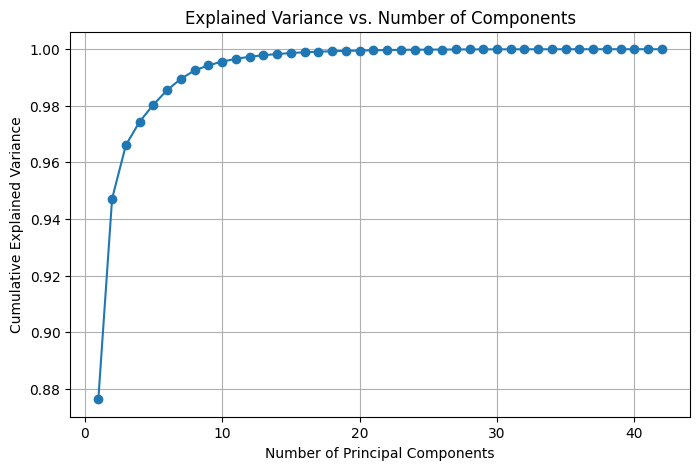

3

In [11]:
estimate_components(fingerprints)

Not good, should look into other FP that can reduce the number of dimensions and still conserve the variance

In [18]:
dataframe = dataframe.drop(columns= ['target_id', 'standard_type', 'target_name', 'standard_relation', 'standard_value', 'standard_units', 'target_organism'])

In [19]:
dataframe.to_csv('data/cleaned_dataset.csv', index = False)

In [ ]:
from config import DATA_FILE_PATH
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder



def one_hot_encode(self, features): 
    one_hot_encoder = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(), features)
        ], 
        remainder= 'passthrough' # Keep the rest of columns as is
    )

    oh_features = one_hot_encoder.fit_transform(features)
    return oh_features

def standarize_data(self, data): 
    scaler = StandardScaler()
    data_standardized = scaler.fit_transform(data)


In [16]:
class DataHandler: 
    def find_input_type(self, file_path=DATA_FILE_PATH):
        self.file_path = file_path
        if file_path.split('.')[-1] == 'csv':
            return True
        elif file_path.split('.')[-1] == 'txt':
            return False 
        else: 
            raise ValueError('Unsupported input file. Only .txt and .csv are supported')

In [ ]:
data_handler = DataHandler()

data_handler.find_input_type(file_path='test.csv')



In [ ]:
from tqdm import tqdm
import pickle


# Load all fingerprints with tqdm progress bar
fingerprints, smiles_list, features = [], [], []
for idx in tqdm(range(75), desc="Loading Fingerprints"):
    with open(f'data/fingerprints_chunk_{idx}.pkl', 'rb') as f:
        fps_chunk, smiles_chunk, features_chunk = pickle.load(f)
        fingerprints.extend(fps_chunk)
        smiles_list.extend(smiles_chunk)
        features.extend(features_chunk)

In [ ]:
from multiprocessing import Pool
from config import N_JOBS
from rdkit import Chem
from mhfp.encoder import MHFPEncoder
smiles = 'CCNC(=O)Nc1cn2c(-c3ncc(C)cn3)cc(-c3cncnc3)cc2n1'

encoder = MHFPEncoder(512)

def calculate_fingerprint(smiles): 
    """Calculate fp for a single SMILES string"""
    fingerprint = encoder.encode(smiles)
    print(fingerprint)
    print(len(fingerprint), type(fingerprint))
    

calculate_fingerprint(smiles)